## Import Libraries

In [20]:
import cv2
import os
import numpy as np
from skimage.feature import graycomatrix, graycoprops
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import albumentations as A
from albumentations.augmentations import transforms as AT
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

In [2]:
output_folder = "augmented_images"
os.makedirs(output_folder, exist_ok=True)

## Import Env File

In [4]:
from dotenv import load_dotenv  

load_dotenv()
datasets_path = os.getenv('DATASET_PATH')
models_path = os.getenv('MODELS_PATH')

## Parameters

In [5]:
classes = ['bali', 'pekalongan']
image_size = (224, 224) 
test_split_ratio = 0.2

## GLCM Function

In [6]:
def extract_glcm_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Tambahkan jarak dan sudut yang bervariasi
    distances = [1, 2, 3]  # Jarak pixel: 1, 2, 3
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]  # Sudut: 0°, 45°, 90°, 135°

    # Hitung GLCM
    glcm = graycomatrix(gray, distances=distances, angles=angles, levels=256, symmetric=True, normed=True)

    # Daftar fitur yang ingin diambil
    props = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']

    features = []

    # Ekstraksi setiap fitur dan flatten hasilnya
    for prop in props:
        prop_values = graycoprops(glcm, prop)  # shape = (len(distances), len(angles))
        features.extend(prop_values.flatten())

    return features

## Data Augmentation

In [7]:
augment = A.Compose([
    A.HorizontalFlip(p=0.8),
    A.RandomBrightnessContrast(p=0.6),
    A.Rotate(limit=15, p=0.7),
    A.Affine(scale=(0.95, 1.05), translate_percent=(0.05, 0.05), rotate=15, p=0.6)  
])
num_augmentations_per_image = 4

## Load The Dataset and Extract The Features

In [9]:
features = []
labels = []

for class_idx, class_name in enumerate(classes):
    folder = os.path.join(datasets_path, class_name)
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        image = cv2.imread(img_path)
        if image is None:
            continue
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, image_size)

        # Tambahkan fitur dari gambar asli juga jika diinginkan
        glcm_features_original = extract_glcm_features(image)
        features.append(glcm_features_original)
        labels.append(class_idx)

        # Tambahkan beberapa augmentasi
        for _ in range(num_augmentations_per_image):
            augmented = augment(image=image)
            aug_image = augmented['image']
            # cv2.imwrite(os.path.join(output_folder, f"aug_{_}_{img_name}"), aug_image)

            glcm_features_aug = extract_glcm_features(aug_image)
            features.append(glcm_features_aug)
            labels.append(class_idx)

features = np.array(features)
labels = np.array(labels)

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    features, labels,
    test_size=test_split_ratio,
    random_state=42,
    stratify=labels  # Menjaga distribusi kelas tetap seimbang
)

In [11]:
# Melihat 10 baris pertama dari X_train
print("X_train sebelum normalisasi (10 baris pertama):")
print(X_train[:10])

X_train sebelum normalisasi (10 baris pertama):
[[3.12230221e+02 6.00771461e+02 3.53245035e+02 5.13959702e+02
  7.73860803e+02 6.00771461e+02 8.69729227e+02 5.13959702e+02
  1.11440736e+03 1.24817306e+03 1.24945475e+03 1.08772943e+03
  1.09530750e+01 1.52905548e+01 1.14297325e+01 1.40520019e+01
  1.78452381e+01 1.52905548e+01 1.85918798e+01 1.40520019e+01
  2.19213801e+01 2.29495780e+01 2.28775048e+01 2.11265928e+01
  2.52269924e-01 2.21351916e-01 2.55816526e-01 2.34429215e-01
  2.03286113e-01 2.21351916e-01 2.08446807e-01 2.34429215e-01
  1.83017229e-01 1.80446887e-01 1.86997547e-01 1.93440946e-01
  1.30563896e-01 1.26597030e-01 1.30968071e-01 1.26660471e-01
  1.24969554e-01 1.26597030e-01 1.25868906e-01 1.26660471e-01
  1.19922423e-01 1.17516629e-01 1.21269398e-01 1.17389031e-01
  9.38282367e-01 8.80898333e-01 9.30344721e-01 8.98108580e-01
  8.46252668e-01 8.80898333e-01 8.27990388e-01 8.98108580e-01
  7.77444563e-01 7.50516277e-01 7.52069755e-01 7.82585608e-01]
 [1.01481756e+03 1.16

In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  
X_test = scaler.transform(X_test)        

In [13]:
# Melihat 10 baris pertama dari X_train
print("X_train sesudah normalisasi (10 baris pertama):")
print(X_train[:10])

X_train sesudah normalisasi (10 baris pertama):
[[-0.60649642 -0.56529211 -0.52274867 -0.66202658 -0.65777422 -0.56529211
  -0.55575059 -0.66202658 -0.69254555 -0.58316669 -0.59365103 -0.69374393
  -0.70831128 -0.60888426 -0.5574251  -0.76513631 -0.73448967 -0.60888426
  -0.58098013 -0.76513631 -0.74891912 -0.5991068  -0.59584097 -0.77478759
   0.43192661  0.36605805  0.39717222  0.50856345  0.38096269  0.36605805
   0.3723775   0.50856345  0.35616456  0.31427581  0.34140669  0.46321038
   0.36592477  0.36923182  0.36338529  0.37160724  0.38240423  0.36923182
   0.38382565  0.37160724  0.38448496  0.3700659   0.3910587   0.37059404
   0.65043862  0.5647607   0.50077296  0.70913747  0.7418591   0.5647607
   0.52072383  0.70913747  0.81289713  0.5812627   0.56221386  0.78989813]
 [ 0.0646279  -0.08157802 -0.15450784  0.16333689  0.19325351 -0.08157802
  -0.05103171  0.16333689  0.15159596 -0.01451828 -0.05742824  0.16238951
   0.18744023 -0.03655231 -0.08892262  0.23096422  0.21260797 -0

In [14]:
# from sklearn.decomposition import PCA

# pca = PCA(n_components=0.95) 
# X_train_pca = pca.fit_transform(X_train)
# X_test_pca = pca.transform(X_test)

In [17]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (768, 60)
X_test shape: (192, 60)


In [16]:
print("Y_train shape:", y_train.shape)
print("Y_test shape:", y_test.shape)

Y_train shape: (768,)
Y_test shape: (192,)


In [18]:
# # Melihat 10 baris pertama dari X_train_pca
# print("X_train_pca (10 baris pertama):")
# print(X_train_pca[:10])

## Train SVM

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Untuk kernel linear
param_grid_linear = {
    'kernel': ['linear'],
    'C': [0.1, 1, 10, 100],
    'shrinking': [True, False],
    'tol': [1e-3, 1e-4],
    'class_weight': [None, 'balanced']
}

# Untuk kernel RBF
param_grid_rbf = {
    'kernel': ['rbf'],
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto'],
    'shrinking': [True, False],
    'tol': [1e-3, 1e-4],
    'class_weight': [None, 'balanced']
}

# Untuk kernel poly
param_grid_poly = {
    'kernel': ['poly'],
    'C': [0.1, 1, 10],
    'degree': [2, 3, 4],
    'gamma': ['scale', 'auto'],
    'coef0': [0.0, 0.1, 0.5],
    'shrinking': [True, False],
    'tol': [1e-3],
    'class_weight': [None]
}

# Gabungkan semua grid
param_grid = [param_grid_linear, param_grid_rbf, param_grid_poly]

grid = GridSearchCV(SVC(), param_grid, cv=5, n_jobs=-1, verbose=2)
grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)
print("Best cross-validation score:", grid.best_score_)


Fitting 5 folds for each of 188 candidates, totalling 940 fits


KeyboardInterrupt: 

## Simplified Version

In [21]:
# Kernel linear (disederhanakan)
param_grid_linear = {
    'kernel': ['linear'],
    'C': [0.1, 1, 10],
    'shrinking': [True, False],
    'tol': [1e-3, 1e-4],
}

# Kernel RBF (disederhanakan)
param_grid_rbf = {
    'kernel': ['rbf'],
    'C': [0.1, 1, 10],
    'shrinking': [True, False],
    'gamma': ['scale'],
    'tol': [1e-3, 1e-4],
}

# Kernel polynomial (disederhanakan)
param_grid_poly = {
    'kernel': ['poly'],
    'C': [0.1, 1, 10],
    'degree': [3],  # paling umum
    'gamma': ['scale'],
    'shrinking': [True, False],
    'coef0': [0.0, 0.1],
    'tol': [1e-3, 1e-4],
}

# Gabungkan
param_grid = [param_grid_linear, param_grid_rbf, param_grid_poly]

grid = GridSearchCV(
    SVC(),
    param_grid,
    cv=5,          # dari 5 → 3 lipat validasi silang
    n_jobs=-1,
    verbose=2 
)

grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)
print("Best cross-validation score:", grid.best_score_)


Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf', 'shrinking': True, 'tol': 0.001}
Best cross-validation score: 0.8242169595110772


In [ ]:
from sklearn.svm import SVC

# Gunakan parameter terbaik dari GridSearchCV
best_model = SVC(C=10, class_weight=None, coef0=0.5, degree=2, gamma='auto', kernel='poly', shrinking=True, tol=0.001)
best_model.fit(X_train, y_train)


SVC(C=10, coef0=0.5, degree=2, gamma='auto', kernel='poly')

## Simplified

In [22]:
from sklearn.svm import SVC

# Gunakan parameter terbaik dari GridSearchCV
best_model = SVC(C=10, gamma='scale', kernel='rbf', shrinking=True, tol=0.001)
best_model.fit(X_train, y_train)


SVC(C=10)

## Evaluates

In [23]:
# Evaluasi model
y_pred = best_model.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix
print("Akurasi:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Akurasi: 0.828125
              precision    recall  f1-score   support

           0       0.86      0.78      0.82        96
           1       0.80      0.88      0.84        96

    accuracy                           0.83       192
   macro avg       0.83      0.83      0.83       192
weighted avg       0.83      0.83      0.83       192



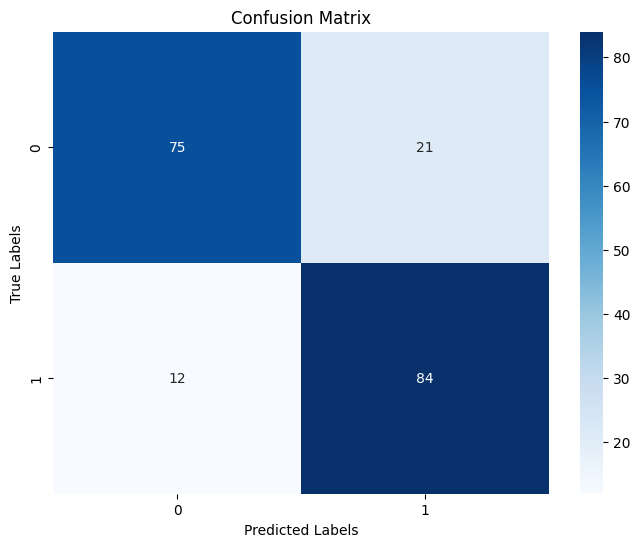

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Buat confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualisasikan dengan heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


## Save The Model

In [25]:
from joblib import dump

# Simpan model ke file
dump(best_model, models_path+'/svm_glcm_model2.joblib')

['D:/Batik-Classifier-Model/Output/svm_glcm_model2.joblib']